In [1]:
import numpy as np
import os
import mne
import pickle
import pandas as pd
from mat73 import loadmat
import matplotlib.pyplot as plt
import osl
import yaml

In [2]:
# Load raw data
raw = loadmat('../data/opm_rich/Task/raw.mat')

In [3]:
raw = raw['data']

In [4]:
# Select bad channels
drop_inds = [78, 79, 80, 30, 31, 32, 48, 49, 50, 63, 64, 65, 12, 13, 14, 3, 4, 5, 0, 1, 2, 6, 7, 8, 105, 106, 107]
good_inds = [i for i in range(186) if i not in drop_inds]

ch_names = [str(i) for i in good_inds]

In [5]:
# Drop bad channels
raw = raw[good_inds, :]

In [6]:
data = raw

In [7]:
# Load channel locations
channels = pd.read_csv('../data/opm_rich/Task/20220908_115229_channels.tsv', sep='\t')

In [8]:
# Set channel locations
chn_dict = []
for i in range(len(channels)):
    if i in good_inds:
        chn_positions = np.array([channels['Px'][i], channels['Py'][i], channels['Pz'][i], 0, 0, 0, 0, 0, 0, 0, 0, 0])

        chd = {'loc': chn_positions, 'ch_name': channels['name'][i], 'kind': 'FIFFV_EEG_CH'}
        chn_dict.append(chd)

In [9]:
# Create info structure
ch_names = [d['ch_name'] for d in chn_dict]
info = mne.create_info(ch_names=ch_names, sfreq=1200, ch_types='eeg')

# set channel locations
for i in range(len(chn_dict)):
    info['chs'][i]['loc'] = chn_dict[i]['loc']

In [10]:
# create mne raw object
raw = mne.io.RawArray(data, info)

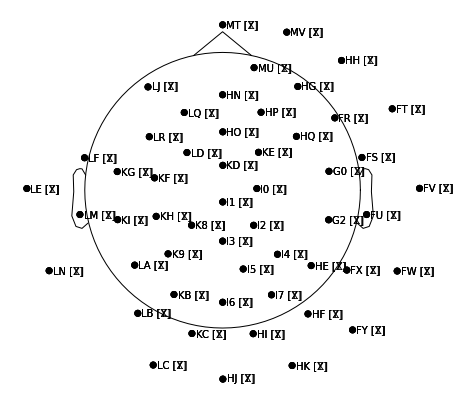

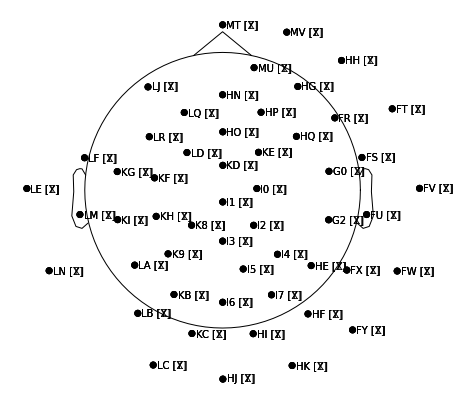

In [11]:
raw.plot_sensors(show_names=True)

In [ ]:
# OSL preproc pipeline
outdir = os.path.join('..', 'data', 'opm_rich')

config_text = """
meta:
  event_codes:
    words/hungry: 2
    words/tired: 3
    words/thirsty: 4
    words/toilet: 5
    words/pain: 6
preproc:
  - filter:         {l_freq: 1, h_freq: 40}
  - notch_filter:   {freqs: 50 100}
  - bad_channels:   {picks: 'eeg'}
  - bad_segments:   {segment_len: 800, picks: 'eeg'}
  - ica_raw:        {picks: 'eeg', n_components: 50}
"""

In [ ]:
# save data
raw.save('../data/opm_rich/Task/raw.fif', overwrite=True)

In [ ]:
# run OSL preprocessing
config = yaml.load(config_text, Loader=yaml.FullLoader)
dataset = osl.preprocessing.run_proc_chain('../data/opm_rich/Task/raw.fif', config, outdir=outdir, overwrite=True)

In [ ]:
# drop bad channels detected by OSL
raw_proc = dataset['raw']
raw_proc = raw_proc.drop_channels(raw_proc.info['bads'])

In [ ]:
# select x, y, z channels
x_inds = [i for i, c in enumerate(raw_proc.ch_names) if '[X]' in c]
y_inds = [i for i, c in enumerate(raw_proc.ch_names) if '[Y]' in c]
z_inds = [i for i, c in enumerate(raw_proc.ch_names) if '[Z]' in c]

In [ ]:
ica = dataset['ica']

In [ ]:
# Get components and sources
comps = ica.get_components()
ica_sources = ica.get_sources(raw_proc).get_data()

In [ ]:
# plot component timeseries and topographies
%matplotlib inline
index = 0

ch_names = [c for c in raw_proc.ch_names if '[Z]' in c]
info_z = raw_proc.copy().pick_channels(ch_names).info
mne.viz.plot_topomap(comps[z_inds, index], info_z)

%matplotlib widget
plt.plot(ica_sources[index][40000:80000], linewidth=0.5)

In [ ]:
# set components to exclude
ica.exclude = [6, 12, 15]

In [ ]:
# apply ica to the data
raw_proc = ica.apply(raw_proc)


In [ ]:
# save data
raw_proc.save('../data/opm_rich/Task/raw_preproc.fif')